# Loading the Dataset

## Loading the correct modules

In [1]:
from nlb_tools.nwb_interface import NWBDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
import pyarrow as pa
import pyarrow.parquet as pq

In [2]:
dataset = NWBDataset("000129/sub-Indy", "*train", split_heldout=False) # Loading the dataa

## Data Cleanup

In [3]:
## Make trial data
# Find when target pos changes
has_change = dataset.data.target_pos.fillna(-1000).diff(axis=0).any(axis=1) # filling NaNs with arbitrary scalar to treat as one block
print(has_change.index[has_change.to_numpy()]) # Times when a change occurs (i.e. when previous one is different, time given)
print(has_change.to_numpy().nonzero()[0].size) # Number of changes

TimedeltaIndex(['0 days 00:00:00.252000', '0 days 00:00:01.352000',
                '0 days 00:00:02.712000', '0 days 00:00:03.952000',
                '0 days 00:00:05.112000', '0 days 00:00:06.364000',
                '0 days 00:00:07.672000', '0 days 00:00:09.064000',
                '0 days 00:00:10.220000', '0 days 00:00:11.300000',
                ...
                '0 days 00:10:36.940000', '0 days 00:10:38.236000',
                '0 days 00:10:39.296000', '0 days 00:10:40.652000',
                '0 days 00:10:41.644000', '0 days 00:10:42.864000',
                '0 days 00:10:43.732000', '0 days 00:10:46.496000',
                '0 days 00:10:47.924000', '0 days 00:10:48.984000'],
               dtype='timedelta64[ns]', name='clock_time', length=551, freq=None)
551


In [4]:
# Find if target pos change corresponds to NaN-padded gap between files
change_nan = dataset.data[has_change].isna().any(axis=1) # Of all data entries where change, where now at NaN, marked as True
print(change_nan.to_numpy().nonzero()) # Indices (within array of changes) where NaN padding ends
print(has_change.to_numpy().nonzero()[0][change_nan.to_numpy()]) # Timestamps of end of NaN padding
print(change_nan)

(array([133, 269, 410]),)
[162200 324500 486800]
clock_time
0 days 00:00:00.252000    False
0 days 00:00:01.352000    False
0 days 00:00:02.712000    False
0 days 00:00:03.952000    False
0 days 00:00:05.112000    False
                          ...  
0 days 00:10:42.864000    False
0 days 00:10:43.732000    False
0 days 00:10:46.496000    False
0 days 00:10:47.924000    False
0 days 00:10:48.984000    False
Length: 551, dtype: bool


In [5]:
# Drop trials containing the gap and immediately before and after, as those trials may be cut short
drop_trial = (change_nan | change_nan.shift(1, fill_value=True) | change_nan.shift(-1, fill_value=True))[:-1]
print(drop_trial)
print(drop_trial.to_numpy().nonzero())

clock_time
0 days 00:00:00.252000     True
0 days 00:00:01.352000    False
0 days 00:00:02.712000    False
0 days 00:00:03.952000    False
0 days 00:00:05.112000    False
                          ...  
0 days 00:10:41.644000    False
0 days 00:10:42.864000    False
0 days 00:10:43.732000    False
0 days 00:10:46.496000    False
0 days 00:10:47.924000    False
Length: 550, dtype: bool
(array([  0, 132, 133, 134, 268, 269, 270, 409, 410, 411]),)


In [6]:
# Add start and end times to trial info
change_times = dataset.data.index[has_change]
start_times = change_times[:-1][~drop_trial]
end_times = change_times[1:][~drop_trial]

In [7]:
# Get target position per trial
target_pos = dataset.data.target_pos.loc[start_times].to_numpy().tolist()

In [8]:
# Compute reach distance and angle
reach_dist = dataset.data.target_pos.loc[end_times - pd.Timedelta(1, 'ms')].to_numpy() - dataset.data.target_pos.loc[start_times - pd.Timedelta(1, 'ms')].to_numpy()
reach_angle = np.arctan2(reach_dist[:, 1], reach_dist[:, 0]) / np.pi * 180
# Create trial info
dataset.trial_info = pd.DataFrame({
    'trial_id': np.arange(len(start_times)),
    'start_time': start_times,
    'end_time': end_times,
    'target_pos': target_pos,
    'reach_dist_x': reach_dist[:, 0],
    'reach_dist_y': reach_dist[:, 1],
    'reach_angle': reach_angle,
})

In [9]:
dataset.trial_info[:132]

,trial_id,start_time,end_time,target_pos,reach_dist_x,reach_dist_y,reach_angle
0,0,0 days 00:00:01.352000,0 days 00:00:02.712000,"[-37.5, 82.5]",-90.0,15.0,170.537678
1,1,0 days 00:00:02.712000,0 days 00:00:03.952000,"[22.5, 67.5]",60.0,-15.0,-14.036243
2,2,0 days 00:00:03.952000,0 days 00:00:05.112000,"[-22.5, 7.5]",-45.0,-60.0,-126.869898
3,3,0 days 00:00:05.112000,0 days 00:00:06.364000,"[-52.5, 67.5]",-30.0,60.0,116.565051
4,4,0 days 00:00:06.364000,0 days 00:00:07.672000,"[-37.5, 52.5]",15.0,-15.0,-45.000000
...,...,...,...,...,...,...,...
127,127,0 days 00:02:37.192000,0 days 00:02:38.276000,"[22.5, 82.5]",30.0,60.0,63.434949
128,128,0 days 00:02:38.276000,0 days 00:02:39.200000,"[-22.5, 52.5]",-45.0,-30.0,-146.309932
129,129,0 days 00:02:39.200000,0 days 00:02:40.272000,"[-7.5, 112.5]",15.0,60.0,75.963757
130,130,0 days 00:02:40.272000,0 days 00:02:41.264000,"[-22.5, 67.5]",-15.0,-45.0,-108.434949


In [10]:
print(dataset.trial_info.end_time[130] - dataset.trial_info.start_time[0])

0 days 00:02:39.912000


In [11]:
dataset.trial_info[131:265]

,trial_id,start_time,end_time,target_pos,reach_dist_x,reach_dist_y,reach_angle
131,131,0 days 00:02:42.744000,0 days 00:02:43.736000,"[22.5, 112.5]",15.0,15.0,45.000000
132,132,0 days 00:02:43.736000,0 days 00:02:44.808000,"[22.5, 37.5]",0.0,-75.0,-90.000000
133,133,0 days 00:02:44.808000,0 days 00:02:46.140000,"[52.5, 37.5]",30.0,0.0,0.000000
134,134,0 days 00:02:46.140000,0 days 00:02:47.164000,"[37.5, 82.5]",-15.0,45.0,108.434949
135,135,0 days 00:02:47.164000,0 days 00:02:48.164000,"[-7.5, 67.5]",-45.0,-15.0,-161.565051
...,...,...,...,...,...,...,...
260,260,0 days 00:05:19.240000,0 days 00:05:20.304000,"[22.5, 67.5]",30.0,60.0,63.434949
261,261,0 days 00:05:20.304000,0 days 00:05:21.308000,"[-52.5, 37.5]",-75.0,-30.0,-158.198591
262,262,0 days 00:05:21.308000,0 days 00:05:22.276000,"[-37.5, 97.5]",15.0,60.0,75.963757
263,263,0 days 00:05:22.276000,0 days 00:05:23.172000,"[-37.5, 82.5]",0.0,-15.0,-90.000000


In [12]:
print(dataset.trial_info.end_time[263] - dataset.trial_info.start_time[131])

0 days 00:02:40.428000


In [13]:
dataset.trial_info[264:403]

,trial_id,start_time,end_time,target_pos,reach_dist_x,reach_dist_y,reach_angle
264,264,0 days 00:05:24.752000,0 days 00:05:25.872000,"[52.5, 37.5]",30.0,15.0,26.565051
265,265,0 days 00:05:25.872000,0 days 00:05:26.844000,"[7.5, 67.5]",-45.0,30.0,146.309932
266,266,0 days 00:05:26.844000,0 days 00:05:27.984000,"[-22.5, 82.5]",-30.0,15.0,153.434949
267,267,0 days 00:05:27.984000,0 days 00:05:29.052000,"[-7.5, 7.5]",15.0,-75.0,-78.690068
268,268,0 days 00:05:29.052000,0 days 00:05:30.004000,"[-37.5, 22.5]",-30.0,15.0,153.434949
...,...,...,...,...,...,...,...
398,398,0 days 00:08:02.436000,0 days 00:08:03.376000,"[7.5, 52.5]",-30.0,15.0,153.434949
399,399,0 days 00:08:03.376000,0 days 00:08:04.504000,"[22.5, 112.5]",15.0,60.0,75.963757
400,400,0 days 00:08:04.504000,0 days 00:08:05.604000,"[7.5, 67.5]",-15.0,-45.0,-108.434949
401,401,0 days 00:08:05.604000,0 days 00:08:06.672000,"[37.5, 97.5]",30.0,30.0,45.000000


In [14]:
print(dataset.trial_info.end_time[401] - dataset.trial_info.start_time[264])

0 days 00:02:41.920000


In [15]:
dataset.trial_info[402:]

,trial_id,start_time,end_time,target_pos,reach_dist_x,reach_dist_y,reach_angle
402,402,0 days 00:08:07.592000,0 days 00:08:08.724000,"[22.5, 97.5]",30.0,15.0,26.565051
403,403,0 days 00:08:08.724000,0 days 00:08:09.724000,"[-7.5, 52.5]",-30.0,-45.0,-123.690068
404,404,0 days 00:08:09.724000,0 days 00:08:10.840000,"[-22.5, 112.5]",-15.0,60.0,104.036243
405,405,0 days 00:08:10.840000,0 days 00:08:11.892000,"[-22.5, 67.5]",0.0,-45.0,-90.000000
406,406,0 days 00:08:11.892000,0 days 00:08:12.952000,"[-37.5, 97.5]",-15.0,30.0,116.565051
...,...,...,...,...,...,...,...
535,535,0 days 00:10:41.644000,0 days 00:10:42.864000,"[-52.5, 82.5]",-105.0,0.0,180.000000
536,536,0 days 00:10:42.864000,0 days 00:10:43.732000,"[-22.5, 67.5]",30.0,-15.0,-26.565051
537,537,0 days 00:10:43.732000,0 days 00:10:46.496000,"[-7.5, 7.5]",15.0,-60.0,-75.963757
538,538,0 days 00:10:46.496000,0 days 00:10:47.924000,"[-52.5, 37.5]",-45.0,30.0,146.309932


In [16]:
print(dataset.trial_info.end_time[539] - dataset.trial_info.start_time[402])

0 days 00:02:41.392000


## Create new dataset containing only the cleaned data

In [17]:
dataset.trial_info.start_time.duplicated().to_numpy().nonzero()[0]

array([], dtype=int64)

In [18]:
fdatastart = dataset.trial_info.start_time
fdataend = dataset.trial_info.end_time
fstartind = np.isin(dataset.data.index, fdatastart).nonzero()[0]
fendindo = np.isin(dataset.data.index, fdataend).nonzero()[0] 
fendind = [fendindo[i] if fendindo[i] == fstartind[i + 1] else fendindo[i] + 1 for i in range(len(fstartind) - 1)]
fendind.append(fendindo[-1] + 1) 
findices = list(zip(fstartind, fendind))
findices = [slice(*i) for i in findices]
print(fstartind[:10])
print(fendind[:10])

[ 1352  2712  3952  5112  6364  7672  9064 10220 11300 13004]
[2712, 3952, 5112, 6364, 7672, 9064, 10220, 11300, 13004, 14040]


In [19]:
dataset.data.iloc[fstartind]

signal_type            cursor_pos            finger_pos                        \
channel                         x          y          x          y          z   
clock_time                                                                      
0 days 00:00:01.352000  56.716570  64.495986  56.699333  64.503225  95.664947   
0 days 00:00:02.712000 -40.262999  83.743483 -40.240357  83.735568  97.336213   
0 days 00:00:03.952000  24.281579  65.337554  24.280212  65.337447  95.121624   
0 days 00:00:05.112000 -21.023642   8.869012 -20.808576   8.911159  94.532066   
0 days 00:00:06.364000 -54.442902  66.411168 -54.362446  66.416733  92.948238   
...                           ...        ...        ...        ...        ...   
0 days 00:10:41.644000  52.145097  86.701076  52.178480  86.556633  90.825436   
0 days 00:10:42.864000 -55.506099  81.996023 -55.490914  81.973781  86.984814   
0 days 00:10:43.732000 -23.239669  66.864777 -23.246911  66.871579  88.075677   
0 days 00:10:46.496000  -4.022756   7.485774  -4.034153   7.552084  87.991721   
0 days 00:10:47.924000 -52.583556  38.249750 -52.590589  38.408304  86.731834   

signal_type            finger_vel            spikes            ...            \
channel                         x          y    201  203  204  ... 9201 9203   
clock_time                                                     ...             
0 days 00:00:01.352000  -2.995598   1.402503    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:00:02.712000   8.737172  -1.785387    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:00:03.952000  -0.734361   0.509484    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:00:05.112000  39.433776   7.263418    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:00:06.364000  16.593732  -0.877898    0.0  0.0  0.0  ...  0.0  0.0   
...                           ...        ...    ...  ...  ...  ...  ...  ...   
0 days 00:10:41.644000   1.406475 -16.957977    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:10:42.864000   1.922883  -2.272901    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:10:43.732000   1.410047  -0.653450    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:10:46.496000  -0.292407   6.216567    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:10:47.924000  -2.075009  28.628266    0.0  0.0  0.0  ...  0.0  0.0   

signal_type                                          target_pos        
channel                9301 9403 9501 9502 9601 9602          x     y  
clock_time                                                             
0 days 00:00:01.352000  0.0  0.0  0.0  0.0  0.0  0.0      -37.5  82.5  
0 days 00:00:02.712000  0.0  0.0  0.0  0.0  0.0  0.0       22.5  67.5  
0 days 00:00:03.952000  0.0  0.0  0.0  0.0  0.0  0.0      -22.5   7.5  
0 days 00:00:05.112000  0.0  0.0  0.0  0.0  0.0  0.0      -52.5  67.5  
0 days 00:00:06.364000  0.0  0.0  0.0  0.0  0.0  0.0      -37.5  52.5  
...                     ...  ...  ...  ...  ...  ...        ...   ...  
0 days 00:10:41.644000  0.0  0.0  0.0  0.0  0.0  0.0      -52.5  82.5  
0 days 00:10:42.864000  0.0  0.0  0.0  0.0  0.0  0.0      -22.5  67.5  
0 days 00:10:43.732000  0.0  0.0  0.0  0.0  0.0  0.0       -7.5   7.5  
0 days 00:10:46.496000  0.0  0.0  0.0  0.0  0.0  0.0      -52.5  37.5  
0 days 00:10:47.924000  0.0  0.0  0.0  0.0  0.0  0.0       22.5  22.5  

[540 rows x 139 columns]

In [20]:
dataset.data.iloc[fendind]

signal_type            cursor_pos            finger_pos                        \
channel                         x          y          x          y          z   
clock_time                                                                      
0 days 00:00:02.712000 -40.262999  83.743483 -40.240357  83.735568  97.336213   
0 days 00:00:03.952000  24.281579  65.337554  24.280212  65.337447  95.121624   
0 days 00:00:05.112000 -21.023642   8.869012 -20.808576   8.911159  94.532066   
0 days 00:00:06.364000 -54.442902  66.411168 -54.362446  66.416733  92.948238   
0 days 00:00:07.672000 -32.683389  53.101256 -32.680823  53.099684  93.419433   
...                           ...        ...        ...        ...        ...   
0 days 00:10:42.864000 -55.506099  81.996023 -55.490914  81.973781  86.984814   
0 days 00:10:43.732000 -23.239669  66.864777 -23.246911  66.871579  88.075677   
0 days 00:10:46.496000  -4.022756   7.485774  -4.034153   7.552084  87.991721   
0 days 00:10:47.924000 -52.583556  38.249750 -52.590589  38.408304  86.731834   
0 days 00:10:48.985000  21.943936  21.766954  21.942857  21.766968  87.764345   

signal_type            finger_vel            spikes            ...            \
channel                         x          y    201  203  204  ... 9201 9203   
clock_time                                                     ...             
0 days 00:00:02.712000   8.737172  -1.785387    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:00:03.952000  -0.734361   0.509484    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:00:05.112000  39.433776   7.263418    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:00:06.364000  16.593732  -0.877898    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:00:07.672000   0.228635   0.115578    0.0  0.0  0.0  ...  0.0  0.0   
...                           ...        ...    ...  ...  ...  ...  ...  ...   
0 days 00:10:42.864000   1.922883  -2.272901    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:10:43.732000   1.410047  -0.653450    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:10:46.496000  -0.292407   6.216567    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:10:47.924000  -2.075009  28.628266    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:10:48.985000  -0.383109   0.009974    0.0  0.0  0.0  ...  0.0  0.0   

signal_type                                          target_pos        
channel                9301 9403 9501 9502 9601 9602          x     y  
clock_time                                                             
0 days 00:00:02.712000  0.0  0.0  0.0  0.0  0.0  0.0       22.5  67.5  
0 days 00:00:03.952000  0.0  0.0  0.0  0.0  0.0  0.0      -22.5   7.5  
0 days 00:00:05.112000  0.0  0.0  0.0  0.0  0.0  0.0      -52.5  67.5  
0 days 00:00:06.364000  0.0  0.0  0.0  0.0  0.0  0.0      -37.5  52.5  
0 days 00:00:07.672000  0.0  0.0  0.0  0.0  0.0  0.0      -22.5  82.5  
...                     ...  ...  ...  ...  ...  ...        ...   ...  
0 days 00:10:42.864000  0.0  0.0  0.0  0.0  0.0  0.0      -22.5  67.5  
0 days 00:10:43.732000  0.0  0.0  0.0  0.0  0.0  0.0       -7.5   7.5  
0 days 00:10:46.496000  0.0  0.0  0.0  0.0  0.0  0.0      -52.5  37.5  
0 days 00:10:47.924000  0.0  0.0  0.0  0.0  0.0  0.0       22.5  22.5  
0 days 00:10:48.985000  0.0  0.0  0.0  0.0  0.0  0.0       37.5  82.5  

[540 rows x 139 columns]

In [21]:
fdata = dataset.data.iloc[np.r_[(*findices,)]]
fdata[2711 - 1352:2715 - 1352]

signal_type            cursor_pos            finger_pos                        \
channel                         x          y          x          y          z   
clock_time                                                                      
0 days 00:00:02.711000 -40.273345  83.745373 -40.249128  83.737352  97.337876   
0 days 00:00:02.712000 -40.262999  83.743483 -40.240357  83.735568  97.336213   
0 days 00:00:02.713000 -40.252776  83.741600 -40.231654  83.733781  97.334565   
0 days 00:00:02.714000 -40.242675  83.739724 -40.223018  83.731992  97.332929   

signal_type            finger_vel           spikes            ...            \
channel                         x         y    201  203  204  ... 9201 9203   
clock_time                                                    ...             
0 days 00:00:02.711000   8.807396 -1.783250    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:00:02.712000   8.737172 -1.785387    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:00:02.713000   8.669275 -1.788065    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:00:02.714000   8.603819 -1.791289    0.0  0.0  0.0  ...  0.0  0.0   

signal_type                                          target_pos        
channel                9301 9403 9501 9502 9601 9602          x     y  
clock_time                                                             
0 days 00:00:02.711000  0.0  0.0  0.0  0.0  0.0  0.0      -37.5  82.5  
0 days 00:00:02.712000  0.0  0.0  0.0  0.0  0.0  0.0       22.5  67.5  
0 days 00:00:02.713000  0.0  0.0  0.0  0.0  0.0  0.0       22.5  67.5  
0 days 00:00:02.714000  0.0  0.0  0.0  0.0  0.0  0.0       22.5  67.5  

[4 rows x 139 columns]

In [22]:
np.where(fdata.index == '0 days 00:02:43.737000')

(array([160906]),)

In [23]:
fdata.index.duplicated().nonzero()[0]

array([], dtype=int64)

In [24]:
fintime = (fdata.index/np.timedelta64(1, 's')).to_numpy()
print(fintime)
fyvel = fdata.finger_vel.x.to_numpy()

[  1.352   1.353   1.354 ... 648.982 648.983 648.984]


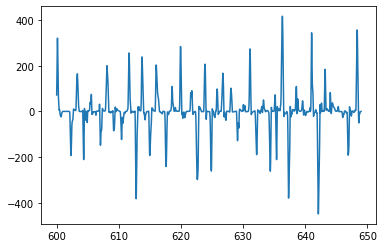

In [25]:
geqind = np.where(fintime > 600)[0][0]
plt.plot(fintime[geqind:], fyvel[geqind:])

## Pick out 4 Super-Trials

In [26]:
(dataset.trial_info.start_time[1:].to_numpy() != dataset.trial_info.end_time[:-1].to_numpy()).nonzero()

(array([130, 263, 401]),)

In [27]:
indshif = (dataset.trial_info.start_time[1:].to_numpy() != dataset.trial_info.end_time[:-1].to_numpy()).nonzero()[0]
indshif1 =  indshif + 2
indicesmis = list(zip(indshif, indshif1))
indicesmis = [slice(*i) for i in indicesmis]
mismatch = dataset.trial_info.iloc[np.r_[(*indicesmis,)]]
mismatch

,trial_id,start_time,end_time,target_pos,reach_dist_x,reach_dist_y,reach_angle
130,130,0 days 00:02:40.272000,0 days 00:02:41.264000,"[-22.5, 67.5]",-15.0,-45.0,-108.434949
131,131,0 days 00:02:42.744000,0 days 00:02:43.736000,"[22.5, 112.5]",15.0,15.0,45.000000
263,263,0 days 00:05:22.276000,0 days 00:05:23.172000,"[-37.5, 82.5]",0.0,-15.0,-90.000000
264,264,0 days 00:05:24.752000,0 days 00:05:25.872000,"[52.5, 37.5]",30.0,15.0,26.565051
401,401,0 days 00:08:05.604000,0 days 00:08:06.672000,"[37.5, 97.5]",30.0,30.0,45.000000
402,402,0 days 00:08:07.592000,0 days 00:08:08.724000,"[22.5, 97.5]",30.0,15.0,26.565051


In [28]:
trial1len = (dataset.trial_info.end_time.iloc[130] - dataset.trial_info.start_time.iloc[0])
print(trial1len / np.timedelta64(1, 's'))
trial2len = (dataset.trial_info.end_time.iloc[263] - dataset.trial_info.start_time.iloc[131])
print(trial2len / np.timedelta64(1, 's'))
trial3len = (dataset.trial_info.end_time.iloc[401] - dataset.trial_info.start_time.iloc[264])
print(trial3len / np.timedelta64(1, 's'))
trial4len = (dataset.trial_info.end_time.iloc[-1] - dataset.trial_info.start_time.iloc[402])
print(trial4len / np.timedelta64(1, 's'))
print(dataset.trial_info.index.to_numpy().shape)

159.912
160.428
161.92
161.392
(540,)


In [29]:
np.where(fdata.index == "0 days 00:02:41.264000")

(array([159912]),)

In [30]:
trial1endind = np.where(fdata.index == dataset.trial_info.end_time[130])[0][0] + 1
trial2endind = np.where(fdata.index == dataset.trial_info.end_time[263])[0][0] + 1
trial3endind = np.where(fdata.index == dataset.trial_info.end_time[401])[0][0] + 1

In [31]:
fdata[trial1endind :trial2endind]

signal_type            cursor_pos            finger_pos                        \
channel                         x          y          x          y          z   
clock_time                                                                      
0 days 00:02:42.744000  11.169541  96.410128  11.187303  96.369149  88.714236   
0 days 00:02:42.745000  11.170761  96.405540  11.188472  96.364969  88.713489   
0 days 00:02:42.746000  11.172008  96.400920  11.189658  96.360769  88.712733   
0 days 00:02:42.747000  11.173281  96.396269  11.190860  96.356552  88.711968   
0 days 00:02:42.748000  11.174581  96.391589  11.192078  96.352317  88.711194   
...                           ...        ...        ...        ...        ...   
0 days 00:05:23.168000 -33.686745  83.697549 -33.693981  83.659222  87.508560   
0 days 00:05:23.169000 -33.687371  83.691077 -33.694584  83.653803  87.508568   
0 days 00:05:23.170000 -33.688007  83.684640 -33.695187  83.648409  87.508574   
0 days 00:05:23.171000 -33.688652  83.678237 -33.695790  83.643040  87.508579   
0 days 00:05:23.172000 -33.689306  83.671873 -33.696392  83.637697  87.508582   

signal_type            finger_vel           spikes            ...            \
channel                         x         y    201  203  204  ... 9201 9203   
clock_time                                                    ...             
0 days 00:02:42.744000   1.160088 -4.171299    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:02:42.745000   1.177165 -4.190024    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:02:42.746000   1.193816 -4.208342    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:02:42.747000   1.210035 -4.226246    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:02:42.748000   1.225813 -4.243727    0.0  0.0  0.0  ...  0.0  0.0   
...                           ...       ...    ...  ...  ...  ...  ...  ...   
0 days 00:05:23.168000  -0.602586 -5.431945    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:05:23.169000  -0.603088 -5.406529    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:05:23.170000  -0.602965 -5.381326    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:05:23.171000  -0.602221 -5.356345    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:05:23.172000  -0.600866 -5.331594    0.0  0.0  0.0  ...  0.0  0.0   

signal_type                                          target_pos         
channel                9301 9403 9501 9502 9601 9602          x      y  
clock_time                                                              
0 days 00:02:42.744000  0.0  0.0  0.0  0.0  0.0  0.0       22.5  112.5  
0 days 00:02:42.745000  0.0  0.0  0.0  0.0  0.0  0.0       22.5  112.5  
0 days 00:02:42.746000  0.0  0.0  0.0  0.0  0.0  0.0       22.5  112.5  
0 days 00:02:42.747000  0.0  0.0  0.0  0.0  0.0  0.0       22.5  112.5  
0 days 00:02:42.748000  0.0  0.0  0.0  0.0  0.0  0.0       22.5  112.5  
...                     ...  ...  ...  ...  ...  ...        ...    ...  
0 days 00:05:23.168000  0.0  1.0  0.0  0.0  0.0  0.0      -37.5   82.5  
0 days 00:05:23.169000  0.0  0.0  0.0  0.0  0.0  0.0      -37.5   82.5  
0 days 00:05:23.170000  0.0  0.0  0.0  0.0  0.0  0.0      -37.5   82.5  
0 days 00:05:23.171000  0.0  0.0  0.0  0.0  0.0  0.0      -37.5   82.5  
0 days 00:05:23.172000  0.0  0.0  0.0  0.0  0.0  0.0      -37.5   52.5  

[160429 rows x 139 columns]

In [32]:
print(trial1endind)

159913


In [33]:
trialtimes = fdata.index.to_numpy()
print(trialtimes[-1])
trialindex = np.asarray([0] * trial1endind + [1] * (trial2endind - trial1endind) + [2] * (trial3endind - trial2endind) + [3] * (np.shape(fdata)[0]- trial3endind))
print(len(trialindex))
print(len(trialtimes))

648984000000 nanoseconds
643656
643656


In [34]:
trialind = list(zip(trialindex, trialtimes))
findex = pd.MultiIndex.from_tuples(trialind)
print(findex)

MultiIndex([(0, '0 days 00:00:01.352000'),
            (0, '0 days 00:00:01.353000'),
            (0, '0 days 00:00:01.354000'),
            (0, '0 days 00:00:01.355000'),
            (0, '0 days 00:00:01.356000'),
            (0, '0 days 00:00:01.357000'),
            (0, '0 days 00:00:01.358000'),
            (0, '0 days 00:00:01.359000'),
            (0, '0 days 00:00:01.360000'),
            (0, '0 days 00:00:01.361000'),
            ...
            (3, '0 days 00:10:48.975000'),
            (3, '0 days 00:10:48.976000'),
            (3, '0 days 00:10:48.977000'),
            (3, '0 days 00:10:48.978000'),
            (3, '0 days 00:10:48.979000'),
            (3, '0 days 00:10:48.980000'),
            (3, '0 days 00:10:48.981000'),
            (3, '0 days 00:10:48.982000'),
            (3, '0 days 00:10:48.983000'),
            (3, '0 days 00:10:48.984000')],
           length=643656)


In [35]:
fdata.set_index(findex, inplace=True)

In [36]:
fdata

signal_type              cursor_pos            finger_pos             \
channel                           x          y          x          y   
0 0 days 00:00:01.352000  56.716570  64.495986  56.699333  64.503225   
  0 days 00:00:01.353000  56.713469  64.497330  56.696334  64.504632   
  0 days 00:00:01.354000  56.710353  64.498684  56.693330  64.506047   
  0 days 00:00:01.355000  56.707223  64.500049  56.690320  64.507470   
  0 days 00:00:01.356000  56.704079  64.501426  56.687305  64.508900   
...                             ...        ...        ...        ...   
3 0 days 00:10:48.980000  21.946345  21.766769  21.944841  21.766884   
  0 days 00:10:48.981000  21.945856  21.766804  21.944433  21.766907   
  0 days 00:10:48.982000  21.945370  21.766840  21.944031  21.766926   
  0 days 00:10:48.983000  21.944887  21.766878  21.943634  21.766943   
  0 days 00:10:48.984000  21.944409  21.766916  21.943243  21.766957   

signal_type                         finger_vel           spikes            \
channel                           z          x         y    201  203  204   
0 0 days 00:00:01.352000  95.664947  -2.995598  1.402503    0.0  0.0  0.0   
  0 days 00:00:01.353000  95.664540  -3.001671  1.410808    0.0  0.0  0.0   
  0 days 00:00:01.354000  95.664133  -3.007234  1.418926    0.0  0.0  0.0   
  0 days 00:00:01.355000  95.663724  -3.012289  1.426852    0.0  0.0  0.0   
  0 days 00:00:01.356000  95.663314  -3.016839  1.434584    0.0  0.0  0.0   
...                             ...        ...       ...    ...  ...  ...   
3 0 days 00:10:48.980000  87.765266  -0.410469  0.023493    0.0  0.0  0.0   
  0 days 00:10:48.981000  87.765070  -0.405038  0.020824    0.0  0.0  0.0   
  0 days 00:10:48.982000  87.764880  -0.399582  0.018134    0.0  0.0  0.0   
  0 days 00:10:48.983000  87.764696  -0.394103  0.015427    0.0  0.0  0.0   
  0 days 00:10:48.984000  87.764517  -0.388607  0.012704    0.0  0.0  0.0   

signal_type               ...                                          \
channel                   ... 9201 9203 9301 9403 9501 9502 9601 9602   
0 0 days 00:00:01.352000  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
  0 days 00:00:01.353000  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
  0 days 00:00:01.354000  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
  0 days 00:00:01.355000  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
  0 days 00:00:01.356000  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...                       ...  ...  ...  ...  ...  ...  ...  ...  ...   
3 0 days 00:10:48.980000  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
  0 days 00:10:48.981000  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
  0 days 00:10:48.982000  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
  0 days 00:10:48.983000  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
  0 days 00:10:48.984000  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

signal_type              target_pos        
channel                           x     y  
0 0 days 00:00:01.352000      -37.5  82.5  
  0 days 00:00:01.353000      -37.5  82.5  
  0 days 00:00:01.354000      -37.5  82.5  
  0 days 00:00:01.355000      -37.5  82.5  
  0 days 00:00:01.356000      -37.5  82.5  
...                             ...   ...  
3 0 days 00:10:48.980000       22.5  22.5  
  0 days 00:10:48.981000       22.5  22.5  
  0 days 00:10:48.982000       22.5  22.5  
  0 days 00:10:48.983000       22.5  22.5  
  0 days 00:10:48.984000       37.5  82.5  

[643656 rows x 139 columns]

In [37]:
fdata.xs(3)

signal_type            cursor_pos            finger_pos                        \
channel                         x          y          x          y          z   
0 days 00:08:07.592000  -5.242279  83.701116  -5.274601  83.566397  88.442598   
0 days 00:08:07.593000  -5.243562  83.684123  -5.276277  83.551680  88.443135   
0 days 00:08:07.594000  -5.244924  83.667138  -5.277998  83.537002  88.443686   
0 days 00:08:07.595000  -5.246364  83.650165  -5.279762  83.522365  88.444252   
0 days 00:08:07.596000  -5.247881  83.633206  -5.281570  83.507771  88.444833   
...                           ...        ...        ...        ...        ...   
0 days 00:10:48.980000  21.946345  21.766769  21.944841  21.766884  87.765266   
0 days 00:10:48.981000  21.945856  21.766804  21.944433  21.766907  87.765070   
0 days 00:10:48.982000  21.945370  21.766840  21.944031  21.766926  87.764880   
0 days 00:10:48.983000  21.944887  21.766878  21.943634  21.766943  87.764696   
0 days 00:10:48.984000  21.944409  21.766916  21.943243  21.766957  87.764517   

signal_type            finger_vel            spikes            ...            \
channel                         x          y    201  203  204  ... 9201 9203   
0 days 00:08:07.592000  -1.653753 -14.736100    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:08:07.593000  -1.698505 -14.697690    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:08:07.594000  -1.742574 -14.657507    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:08:07.595000  -1.785958 -14.615533    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:08:07.596000  -1.828660 -14.571765    0.0  1.0  0.0  ...  0.0  0.0   
...                           ...        ...    ...  ...  ...  ...  ...  ...   
0 days 00:10:48.980000  -0.410469   0.023493    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:10:48.981000  -0.405038   0.020824    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:10:48.982000  -0.399582   0.018134    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:10:48.983000  -0.394103   0.015427    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:10:48.984000  -0.388607   0.012704    0.0  0.0  0.0  ...  0.0  0.0   

signal_type                                          target_pos        
channel                9301 9403 9501 9502 9601 9602          x     y  
0 days 00:08:07.592000  0.0  0.0  0.0  0.0  0.0  0.0       22.5  97.5  
0 days 00:08:07.593000  0.0  0.0  0.0  0.0  0.0  0.0       22.5  97.5  
0 days 00:08:07.594000  0.0  0.0  0.0  0.0  0.0  0.0       22.5  97.5  
0 days 00:08:07.595000  0.0  0.0  0.0  0.0  0.0  0.0       22.5  97.5  
0 days 00:08:07.596000  0.0  0.0  0.0  0.0  0.0  0.0       22.5  97.5  
...                     ...  ...  ...  ...  ...  ...        ...   ...  
0 days 00:10:48.980000  0.0  0.0  0.0  0.0  0.0  0.0       22.5  22.5  
0 days 00:10:48.981000  0.0  0.0  0.0  0.0  0.0  0.0       22.5  22.5  
0 days 00:10:48.982000  0.0  0.0  0.0  0.0  0.0  0.0       22.5  22.5  
0 days 00:10:48.983000  0.0  0.0  0.0  0.0  0.0  0.0       22.5  22.5  
0 days 00:10:48.984000  0.0  0.0  0.0  0.0  0.0  0.0       37.5  82.5  

[161393 rows x 139 columns]

In [38]:
newtimes = np.asarray([j for k in [fdata.xs(i).index - fdata.xs(i).index[0] for i in range(4)] for j in k])

In [39]:
trialind = list(zip(trialindex, newtimes))
findex = pd.MultiIndex.from_tuples(trialind)
print(findex)

MultiIndex([(0,        '0 days 00:00:00'),
            (0, '0 days 00:00:00.001000'),
            (0, '0 days 00:00:00.002000'),
            (0, '0 days 00:00:00.003000'),
            (0, '0 days 00:00:00.004000'),
            (0, '0 days 00:00:00.005000'),
            (0, '0 days 00:00:00.006000'),
            (0, '0 days 00:00:00.007000'),
            (0, '0 days 00:00:00.008000'),
            (0, '0 days 00:00:00.009000'),
            ...
            (3, '0 days 00:02:41.383000'),
            (3, '0 days 00:02:41.384000'),
            (3, '0 days 00:02:41.385000'),
            (3, '0 days 00:02:41.386000'),
            (3, '0 days 00:02:41.387000'),
            (3, '0 days 00:02:41.388000'),
            (3, '0 days 00:02:41.389000'),
            (3, '0 days 00:02:41.390000'),
            (3, '0 days 00:02:41.391000'),
            (3, '0 days 00:02:41.392000')],
           length=643656)


In [40]:
fdata.xs(3).index.duplicated().nonzero()

(array([], dtype=int64),)

In [41]:
fdata.set_index(findex, inplace=True)

In [42]:
fdata.xs(3)

signal_type            cursor_pos            finger_pos                        \
channel                         x          y          x          y          z   
0 days 00:00:00         -5.242279  83.701116  -5.274601  83.566397  88.442598   
0 days 00:00:00.001000  -5.243562  83.684123  -5.276277  83.551680  88.443135   
0 days 00:00:00.002000  -5.244924  83.667138  -5.277998  83.537002  88.443686   
0 days 00:00:00.003000  -5.246364  83.650165  -5.279762  83.522365  88.444252   
0 days 00:00:00.004000  -5.247881  83.633206  -5.281570  83.507771  88.444833   
...                           ...        ...        ...        ...        ...   
0 days 00:02:41.388000  21.946345  21.766769  21.944841  21.766884  87.765266   
0 days 00:02:41.389000  21.945856  21.766804  21.944433  21.766907  87.765070   
0 days 00:02:41.390000  21.945370  21.766840  21.944031  21.766926  87.764880   
0 days 00:02:41.391000  21.944887  21.766878  21.943634  21.766943  87.764696   
0 days 00:02:41.392000  21.944409  21.766916  21.943243  21.766957  87.764517   

signal_type            finger_vel            spikes            ...            \
channel                         x          y    201  203  204  ... 9201 9203   
0 days 00:00:00         -1.653753 -14.736100    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:00:00.001000  -1.698505 -14.697690    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:00:00.002000  -1.742574 -14.657507    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:00:00.003000  -1.785958 -14.615533    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:00:00.004000  -1.828660 -14.571765    0.0  1.0  0.0  ...  0.0  0.0   
...                           ...        ...    ...  ...  ...  ...  ...  ...   
0 days 00:02:41.388000  -0.410469   0.023493    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:02:41.389000  -0.405038   0.020824    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:02:41.390000  -0.399582   0.018134    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:02:41.391000  -0.394103   0.015427    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:02:41.392000  -0.388607   0.012704    0.0  0.0  0.0  ...  0.0  0.0   

signal_type                                          target_pos        
channel                9301 9403 9501 9502 9601 9602          x     y  
0 days 00:00:00         0.0  0.0  0.0  0.0  0.0  0.0       22.5  97.5  
0 days 00:00:00.001000  0.0  0.0  0.0  0.0  0.0  0.0       22.5  97.5  
0 days 00:00:00.002000  0.0  0.0  0.0  0.0  0.0  0.0       22.5  97.5  
0 days 00:00:00.003000  0.0  0.0  0.0  0.0  0.0  0.0       22.5  97.5  
0 days 00:00:00.004000  0.0  0.0  0.0  0.0  0.0  0.0       22.5  97.5  
...                     ...  ...  ...  ...  ...  ...        ...   ...  
0 days 00:02:41.388000  0.0  0.0  0.0  0.0  0.0  0.0       22.5  22.5  
0 days 00:02:41.389000  0.0  0.0  0.0  0.0  0.0  0.0       22.5  22.5  
0 days 00:02:41.390000  0.0  0.0  0.0  0.0  0.0  0.0       22.5  22.5  
0 days 00:02:41.391000  0.0  0.0  0.0  0.0  0.0  0.0       22.5  22.5  
0 days 00:02:41.392000  0.0  0.0  0.0  0.0  0.0  0.0       37.5  82.5  

[161393 rows x 139 columns]

In [43]:
finger_veldata = fdata.drop(['cursor_pos', 'target_pos', 'finger_pos'], axis = 1)

In [44]:
finger_veldata.to_hdf('./Data/Allfinger_veldata.h5', 'data')
finger_veldata.to_pickle('./Data/Allfinger_veldata', protocol=4)

/home/sgome/Project/Bayesian-Convolutional-Model/Simple-Model/.venv/lib/python3.8/site-packages/pandas/io/pytables.py:296: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->axis0_level1] [items->None]

  f = lambda store: store.put(
/home/sgome/Project/Bayesian-Convolutional-Model/Simple-Model/.venv/lib/python3.8/site-packages/pandas/io/pytables.py:296: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_items_level1] [items->None]

  f = lambda store: store.put(
/home/sgome/Project/Bayesian-Convolutional-Model/Simple-Model/.venv/lib/python3.8/site-packages/pandas/io/pytables.py:296: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_items_level1] [it